In [1]:
%load_ext autoreload
%autoreload 2

import modish
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

sns.set(style='ticks', context='talk', rc={'font.sans-serif':'Arial', 'pdf.fonttype': 42})

%matplotlib inline



import flotilla

study = flotilla.embark('singlecell_pnm_figure1_supplementary_post_splicing_filtering')

not_outliers = study.splicing.singles.index.difference(study.splicing.outliers.index)
folder = '/home/obotvinnik/Dropbox/figures2/singlecell_pnm/figure2_modalities/bayesian'
! mkdir $folder

/home/obotvinnik/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:784: UserWarning: Found matplotlib configuration in ~/.matplotlib/. To conform with the XDG base directory standard, this configuration location has been deprecated on Linux, and the new location is now /home/obotvinnik/.config/matplotlib/. Please move your configuration there to ensure that matplotlib will continue to find it in the future.
  _get_xdg_config_dir())
/home/obotvinnik/anaconda/lib/python2.7/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


2015-12-02 13:55:09	Reading datapackage from /home/obotvinnik/flotilla_projects/singlecell_pnm_figure1_supplementary_post_splicing_filtering/datapackage.json
2015-12-02 13:55:09	Parsing datapackage to create a Study object
2015-12-02 13:55:55	Initializing Study
2015-12-02 13:55:55	Initializing Predictor configuration manager for Study
2015-12-02 13:55:55	Predictor ExtraTreesClassifier is of type <class 'sklearn.ensemble.forest.ExtraTreesClassifier'>
2015-12-02 13:55:55	Added ExtraTreesClassifier to default predictors
2015-12-02 13:55:55	Predictor ExtraTreesRegressor is of type <class 'sklearn.ensemble.forest.ExtraTreesRegressor'>
2015-12-02 13:55:55	Added ExtraTreesRegressor to default predictors
2015-12-02 13:55:55	Predictor GradientBoostingClassifier is of type <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
2015-12-02 13:55:55	Added GradientBoostingClassifier to default predictors
2015-12-02 13:55:55	Predictor GradientBoostingRegressor is of type <class 'skle

In [2]:
splicing_singles_no_outliers = study.splicing.singles.ix[not_outliers]
print splicing_singles_no_outliers.shape

(181, 11767)


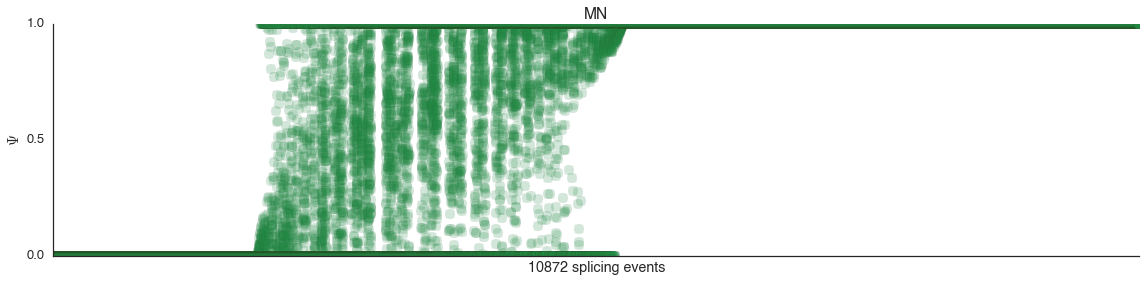

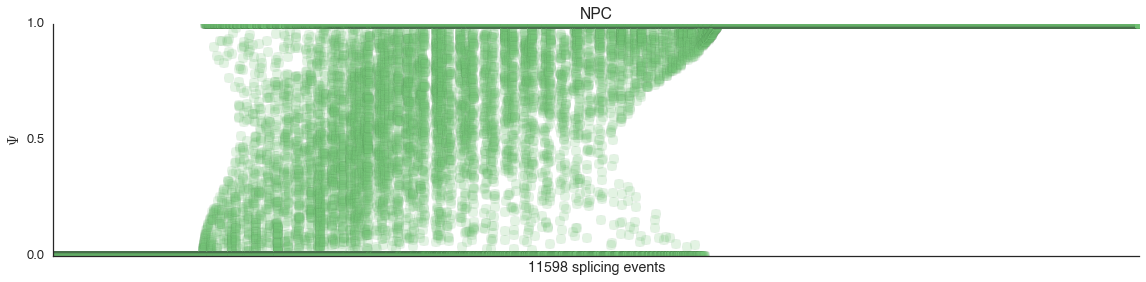

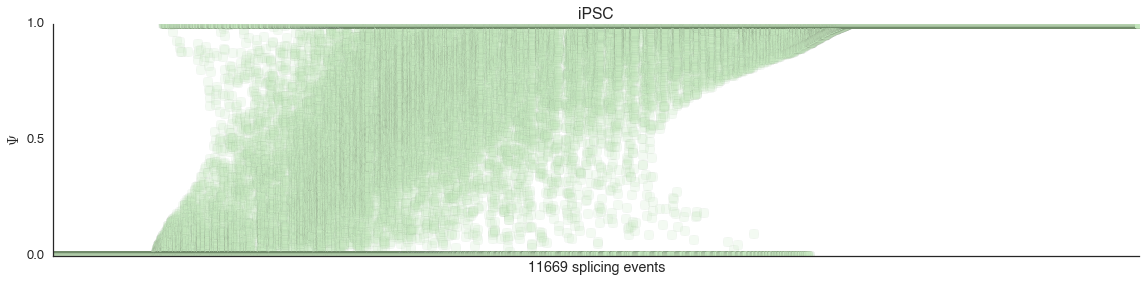

In [3]:
for phenotype, data in splicing_singles_no_outliers.groupby(study.sample_id_to_phenotype):

    flotilla.visualize.splicing.lavalamp(data, color=study.phenotype_to_color[phenotype], title=phenotype)

    fig = plt.gcf()
    fig.tight_layout()
    fig.savefig('{}/lavalamp_{}.png'.format(folder, phenotype))

## Estimate modalities

### Initialize the modality estimator

In [4]:
import anchor

monte_carlo = anchor.MonteCarloModalities()

AttributeError: 'module' object has no attribute 'MonteCarloModalities'

In [ ]:
# fig = estimator.violinplot(n=1e6)
# for ax in fig.axes:
#     ax.set(yticks=[0, 0.5, 1], xlabel='')
# fig.tight_layout()
# sns.despine()
# fig.savefig('{}/modality_estimator_parameterized_family.pdf'.format(folder))

## Calculate/Estimate modalities only on single cells, with no outliers

And at least 20 cells per splicing event, per celltype/phenotype

In [ ]:
print splicing_singles_no_outliers.shape
splicing_singles_no_outliers = splicing_singles_no_outliers.groupby(
    study.sample_id_to_phenotype).apply(lambda x: x.dropna(thresh=20, axis=1))
print splicing_singles_no_outliers.shape

In [ ]:
pkm_events = study.splicing.maybe_renamed_to_feature_id('PKM')

In [ ]:
for phenotype, data in splicing_singles_no_outliers.groupby(study.sample_id_to_phenotype):

    flotilla.visualize.splicing.lavalamp(data, color=study.phenotype_to_color[phenotype], title=phenotype)

    fig = plt.gcf()
    fig.tight_layout()
    fig.savefig('{}/lavalamp_{}_20cells.png'.format(folder, phenotype))

In [ ]:
%time modality_scores = splicing_singles_no_outliers.groupby(study.sample_id_to_phenotype).apply(monte_carlo.fit_predict)

Look at the scores

In [ ]:
modality_scores

Make a "tidy"/"tall" version of the modalities

In [58]:
modality_scores_tidy = pd.melt(modality_scores.reset_index(), id_vars=['phenotype', 'level_1'], 
                               var_name='event_name', value_name='log2_bayes_factor')
modality_scores_tidy = modality_scores_tidy.rename(columns={'level_1': 'modality'})
modality_scores_tidy = modality_scores_tidy.dropna()
print modality_scores_tidy.shape
modality_scores_tidy.head()

(35556, 4)


,phenotype,modality,event_name,log2_bayes_factor
8,iPSC,~0,exon:chr10:101165513-101165617:-@exon:chr10:10...,-176.373342
9,iPSC,~1,exon:chr10:101165513-101165617:-@exon:chr10:10...,46.056652
20,iPSC,~0,exon:chr10:101480744-101480825:-@exon:chr10:10...,-171.189335
21,iPSC,~1,exon:chr10:101480744-101480825:-@exon:chr10:10...,47.544201
32,iPSC,~0,exon:chr10:101507014-101507147:+@exon:chr10:10...,-145.420439


### Plot the $\log_2$ Bayes factors for the modalities

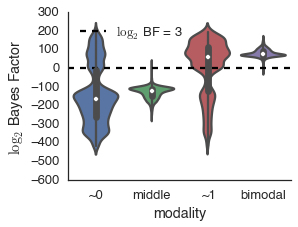

In [59]:
fig, ax = plt.subplots(figsize=(4, 3))
sns.violinplot(x='modality', y='log2_bayes_factor', data=modality_scores_tidy, order=['~0', 'middle', '~1', 'bimodal'],
              scale='width')
# sns.stripplot(x='modality', y='log2_bayes_factor', data=modality_scores_tidy, jitter=True)
xmin, xmax = ax.get_xlim()
ax.set_ylabel('$\log_2$ Bayes Factor')
ax.hlines(3, xmin, xmax, linestyle='dashed', label='$\log_2$ BF = 3')
ax.legend(loc='best')
sns.despine()

In [60]:
modality_scores_tidy.to_csv('{}/modalities_log2bf_tidy.csv'.format(folder), 
                            index=False)

In [61]:
modality_scores_tidy = pd.read_csv('{}/modalities_log2bf_tidy.csv'.format(folder))

Make sure RPS24 is middle for iPSC

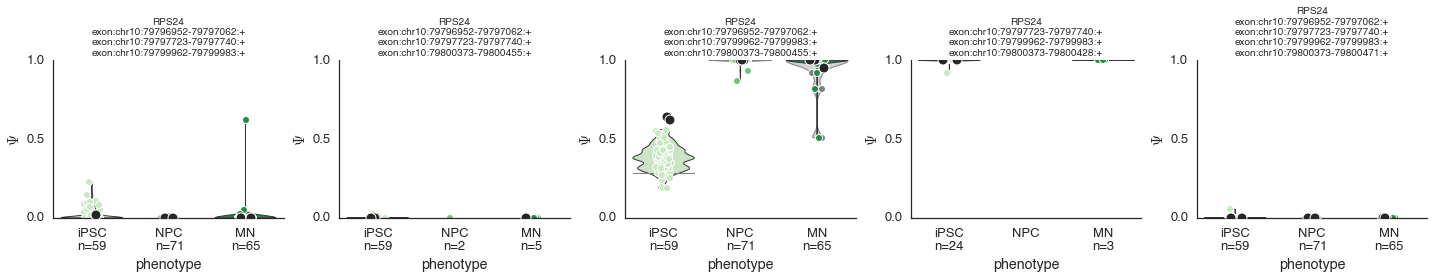

In [62]:
study.plot_event('RPS24')

In [63]:
rps24_junctions = study.splicing.maybe_renamed_to_feature_id("RPS24")

# middle_rps24_junction = rps24_junctions[6]

modality_scores_tidy.loc[modality_scores_tidy.event_name.isin(rps24_junctions)]

,phenotype,modality,event_name,log2_bayes_factor
1242,MN,~0,exon:chr10:79796952-79797062:+@exon:chr10:7979...,141.097705
1243,MN,~1,exon:chr10:79796952-79797062:+@exon:chr10:7979...,-331.303597
1244,NPC,~0,exon:chr10:79796952-79797062:+@exon:chr10:7979...,196.530783
1245,NPC,~1,exon:chr10:79796952-79797062:+@exon:chr10:7979...,-419.323182
1246,iPSC,~0,exon:chr10:79796952-79797062:+@exon:chr10:7979...,139.585601
1247,iPSC,~1,exon:chr10:79796952-79797062:+@exon:chr10:7979...,-270.539307
1248,MN,~0,exon:chr10:79796952-79797062:+@exon:chr10:7979...,160.839662
1249,MN,~1,exon:chr10:79796952-79797062:+@exon:chr10:7979...,-344.747884
1250,NPC,~0,exon:chr10:79796952-79797062:+@exon:chr10:7979...,196.530783
1251,NPC,~1,exon:chr10:79796952-79797062:+@exon:chr10:7979...,-419.323182


,phenotype,modality,event_name,log2_bayes_factor
16610,MN,~0,exon:chr1:23670704-23670755:-@exon:chr1:236673...,-22.392236
16611,MN,~1,exon:chr1:23670704-23670755:-@exon:chr1:236673...,-152.065338
16612,MN,bimodal,exon:chr1:23670704-23670755:-@exon:chr1:236673...,89.444878
16613,MN,middle,exon:chr1:23670704-23670755:-@exon:chr1:236673...,-156.105462
16614,NPC,~0,exon:chr1:23670704-23670755:-@exon:chr1:236673...,-28.562006
16615,NPC,~1,exon:chr1:23670704-23670755:-@exon:chr1:236673...,-157.994043
16616,NPC,bimodal,exon:chr1:23670704-23670755:-@exon:chr1:236673...,73.116915
16617,NPC,middle,exon:chr1:23670704-23670755:-@exon:chr1:236673...,-158.472773
16618,iPSC,~0,exon:chr1:23670704-23670755:-@exon:chr1:236673...,-5.826232
16619,iPSC,~1,exon:chr1:23670704-23670755:-@exon:chr1:236673...,-102.269592


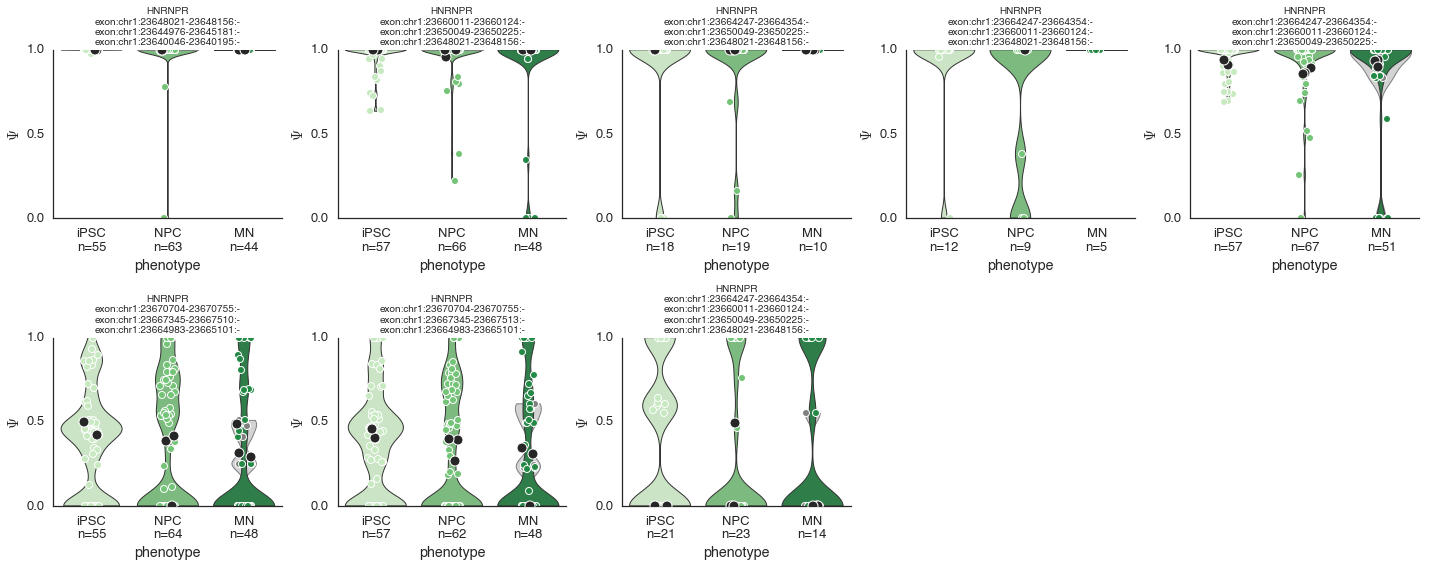

In [84]:
gene_name = 'HNRNPR'

events = study.splicing.maybe_renamed_to_feature_id(gene_name)[5:6]

study.plot_event(gene_name)
# middle_rps24_junction = rps24_junctions[6]

modality_scores_tidy.loc[modality_scores_tidy.event_name.isin(events)]

,phenotype,modality,event_name,log2_bayes_factor
6638,MN,~0,exon:chr14:21737457-21737548:-@exon:chr14:2173...,-145.154704
6639,MN,~1,exon:chr14:21737457-21737548:-@exon:chr14:2173...,-9.607416
6640,MN,bimodal,exon:chr14:21737457-21737548:-@exon:chr14:2173...,72.360685
6641,MN,middle,exon:chr14:21737457-21737548:-@exon:chr14:2173...,-136.004542
6642,NPC,~0,exon:chr14:21737457-21737548:-@exon:chr14:2173...,-211.218955
6643,NPC,~1,exon:chr14:21737457-21737548:-@exon:chr14:2173...,53.242716
6644,iPSC,~0,exon:chr14:21737457-21737548:-@exon:chr14:2173...,-43.511822
6645,iPSC,~1,exon:chr14:21737457-21737548:-@exon:chr14:2173...,10.740632


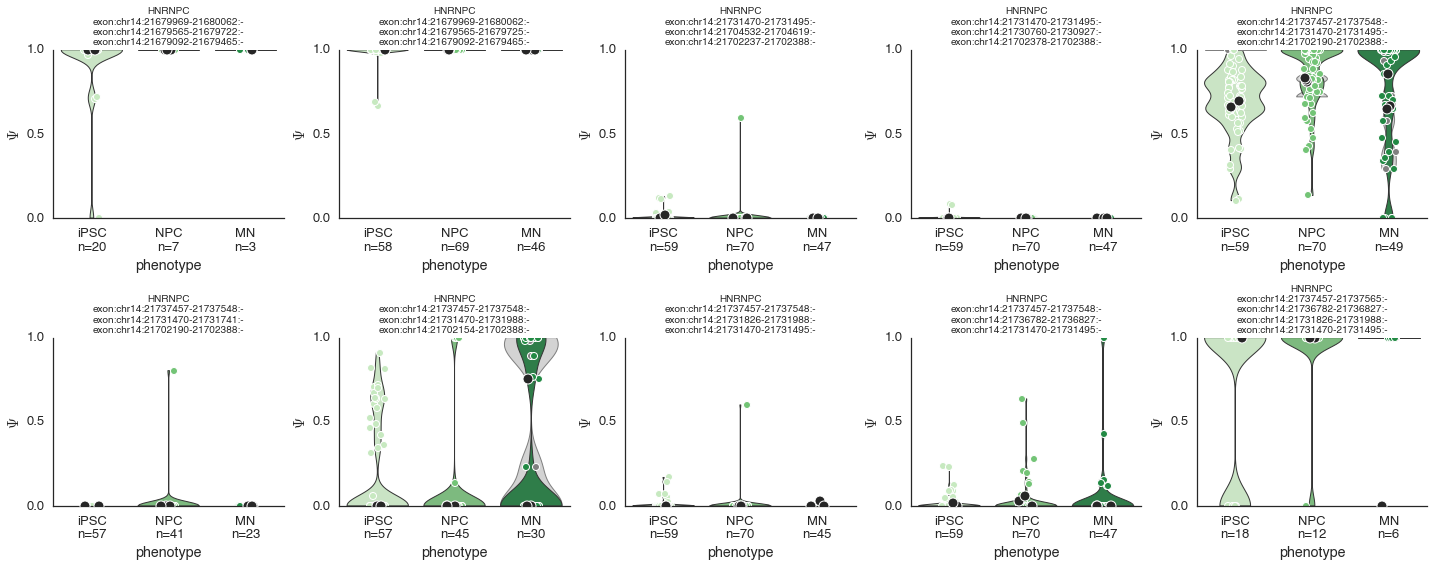

In [83]:
gene_name = 'HNRNPC'

events = study.splicing.maybe_renamed_to_feature_id("HNRNPC")[4:5]

study.plot_event(gene_name)
# middle_rps24_junction = rps24_junctions[6]

modality_scores_tidy.loc[modality_scores_tidy.event_name.isin(events)]

Make sure PKM is bimodal for motor neurons

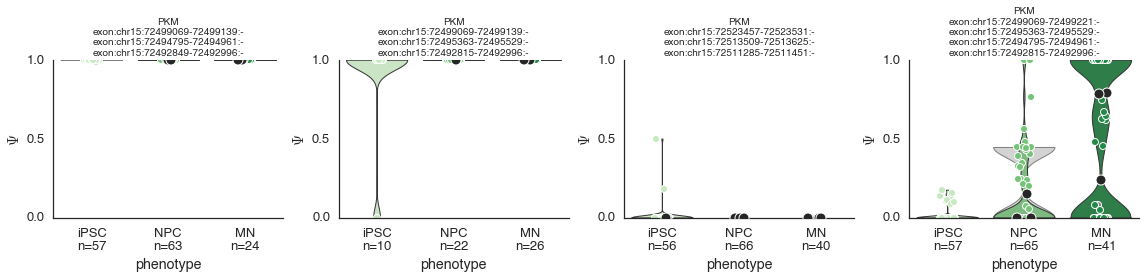

In [64]:
study.plot_event('PKM')

In [65]:
pkm_events = study.splicing.maybe_renamed_to_feature_id('PKM')
modality_scores_tidy.ix[modality_scores_tidy.event_name.isin(pkm_events)]

,phenotype,modality,event_name,log2_bayes_factor
9078,NPC,~0,exon:chr15:72499069-72499139:-@exon:chr15:7249...,-382.035533
9079,NPC,~1,exon:chr15:72499069-72499139:-@exon:chr15:7249...,178.682923
9080,iPSC,~0,exon:chr15:72499069-72499139:-@exon:chr15:7249...,-348.433007
9081,iPSC,~1,exon:chr15:72499069-72499139:-@exon:chr15:7249...,163.592989
9082,MN,~0,exon:chr15:72499069-72499139:-@exon:chr15:7249...,-158.309641
9083,MN,~1,exon:chr15:72499069-72499139:-@exon:chr15:7249...,71.798347
9084,NPC,~0,exon:chr15:72499069-72499139:-@exon:chr15:7249...,-133.451209
9085,NPC,~1,exon:chr15:72499069-72499139:-@exon:chr15:7249...,59.979161
9086,MN,~0,exon:chr15:72499069-72499221:-@exon:chr15:7249...,-104.980663
9087,MN,~1,exon:chr15:72499069-72499221:-@exon:chr15:7249...,-35.691845


### From the scores, assign the most likely modality to each event, per celltype

Notice that we're using the "untidy"/2d/"wide" dataframe of the modality scores

In [66]:

%time modality_assignments = modality_scores.groupby(level=0, axis=0).apply(estimator.assign_modalities, reset_index=True)
modality_assignments
modalities_tidy = modality_assignments.unstack().reset_index()
modalities_tidy = modalities_tidy.rename(columns={'level_0': 'event_name', 0:'modality'})
modalities_tidy = modalities_tidy.dropna()
modalities_tidy.head()

CPU times: user 1.2 s, sys: 5 ms, total: 1.2 s
Wall time: 1.2 s


,event_name,phenotype,modality
2,exon:chr10:101165513-101165617:-@exon:chr10:10...,iPSC,~1
5,exon:chr10:101480744-101480825:-@exon:chr10:10...,iPSC,~1
8,exon:chr10:101507014-101507147:+@exon:chr10:10...,iPSC,bimodal
11,exon:chr10:101997779-101997988:-@exon:chr10:10...,iPSC,~1
14,exon:chr10:102003455-102003529:-@exon:chr10:10...,iPSC,~1


In [67]:
phenotype_event_count = splicing_singles_no_outliers.groupby(study.sample_id_to_phenotype).count()
phenotype_event_count = phenotype_event_count.unstack()
phenotype_event_count = phenotype_event_count.reset_index()
phenotype_event_count = phenotype_event_count.rename(columns={'level_0': 'event_name', 0: 'n_cells'})
print phenotype_event_count.shape
phenotype_event_count = phenotype_event_count.loc[phenotype_event_count.n_cells >= 20]
print phenotype_event_count.shape
phenotype_event_count.head()

(24375, 3)
(15169, 3)


,event_name,phenotype,n_cells
2,exon:chr10:101165513-101165617:-@exon:chr10:10...,iPSC,29
5,exon:chr10:101480744-101480825:-@exon:chr10:10...,iPSC,31
8,exon:chr10:101507014-101507147:+@exon:chr10:10...,iPSC,39
11,exon:chr10:101997779-101997988:-@exon:chr10:10...,iPSC,30
14,exon:chr10:102003455-102003529:-@exon:chr10:10...,iPSC,27


In [68]:
modalities_tidy.shape

(15169, 3)

In [69]:
modalities_tidy = modalities_tidy.merge(phenotype_event_count, 
                                        left_on=['event_name', 'phenotype'], 
                                        right_on=['event_name', 'phenotype'])

In [70]:
modalities_tidy.to_csv('{}/modalities_tidy.csv'.format(folder), index=False)

In [73]:
study.supplemental.modalities_tidy = modalities_tidy

In [72]:
study.save('singlecell_pnm_figure2_modalities')

Wrote datapackage to /home/obotvinnik/flotilla_projects/singlecell_pnm_figure2_modalities/datapackage.json


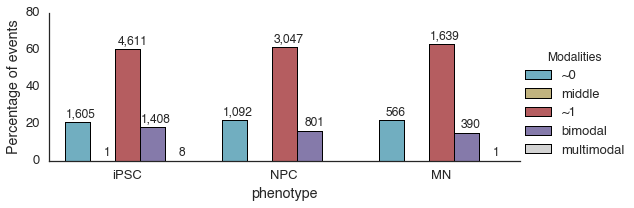

In [74]:
import locale
locale.setlocale(locale.LC_ALL, 'en_US')

modality_counts = study.supplemental.modalities_tidy.groupby(['phenotype', 'modality']).size().reset_index()
modality_counts = modality_counts.rename(columns={0:'n_events'})
modality_counts
modality_counts['Percentage of events'] = modality_counts.groupby('phenotype').n_events.apply(
    lambda x: 100*x/x.astype(float).sum())
modality_counts.head()

def annotate_bars(x, y, **kwargs):
    data = kwargs.pop('data')
    ax = plt.gca()
    width = 0.8/5.
    x_base = -.47 - width/2.5
    for phenotype, phenotype_df in data.groupby('phenotype'):
        i = 0
        for modality, modality_df in phenotype_df.groupby('modality'):
            i += 1
            x_position = x_base + width*i + width/2
            y_position = modality_df["Percentage of events"]
            try:
                value = modality_df.n_events.values[0]
                formatted = locale.format('%d', value, grouping=True)
                ax.annotate(formatted, (x_position, y_position),
                            textcoords='offset points', xytext=(0, 2),
                            ha='center', va='bottom', fontsize=12)
            except IndexError:
                continue
        x_base += 1

        


modality_factorplot_kws = dict(hue_order=MODALITY_ORDER, order=study.phenotype_order, palette=MODALITY_PALETTE)

modality_counts.phenotype = pd.Categorical(modality_counts.phenotype, categories=study.phenotype_order,
                                          ordered=True)
modality_counts.modality = pd.Categorical(modality_counts.modality, categories=MODALITY_ORDER, ordered=True)
g = sns.factorplot(y='Percentage of events', x='phenotype', hue='modality', kind='bar', data=modality_counts,
                   aspect=2.5, legend=False, linewidth=1, size=3, **modality_factorplot_kws)
g.map_dataframe(annotate_bars, 'phenotype', 'Percentage of events')
g.add_legend(label_order=MODALITY_ORDER, title='Modalities')
for ax in g.axes.flat:
#     ax.set_ylim(0, 50)
    ax.locator_params('y', nbins=5)
g.savefig('{}/modalities_bar_percentage.pdf'.format(folder))


In [ ]:
pd.dis

In [78]:
ind = study.supplemental.modalities_tidy.modality.isin(('middle', 'multimodal'))
middle_multimodal = study.supplemental.modalities_tidy.loc[ind]
middle_multimodal = middle_multimodal.join(study.splicing.feature_data.gene_name, on='event_name')
middle_multimodal

,event_name,phenotype,modality,n_cells,gene_name
543,exon:chr10:79796952-79797062:+@exon:chr10:7979...,iPSC,middle,58,RPS24
773,exon:chr11:134119061-134119156:-@exon:chr11:13...,iPSC,multimodal,58,THYN1
2199,exon:chr12:56554027-56554104:+@exon:chr12:5655...,MN,multimodal,55,MYL6
8267,exon:chr20:47895641-47895745:+@exon:chr20:4789...,iPSC,multimodal,58,ZFAS1
8273,exon:chr20:47897022-47897107:+@exon:chr20:4789...,iPSC,multimodal,58,ZFAS1
9619,exon:chr2:27995541-27995559:+@exon:chr2:279972...,iPSC,multimodal,57,MRPL33
11465,exon:chr4:83277949-83278048:-@exon:chr4:832776...,iPSC,multimodal,58,HNRNPD
12133,exon:chr5:43313458-43313575:-@exon:chr5:433078...,iPSC,multimodal,56,HMGCS1
13435,exon:chr7:30544185-30544415:-@exon:chr7:305401...,iPSC,multimodal,58,GGCT
14236,exon:chr8:73939175-73939287:+@exon:chr8:739425...,iPSC,multimodal,58,TERF1
